# Fruit Quality Classification Exercise using KNN classifiers

In this notebook, we'll go through and explore a fruit goodness dataset, build a few classifiers using standard pre-coded classifier code using python libraries, and then ultimately code up our own from-scratch KNN classifier that we have coded ourselves and compare how it works. Using our own code, we'll look at the $k$ value to see how it effects the quality of the classifier on both the training and test sets. To address this problem, you need to write the code wherever it says **FILLIN** or `**FILLIN**` below. 

**The code you produce *must* be your own code, that you wrote yourself without help from anything other than your own brain.**

### Analysis of the histograms

From the above histograms, and from the perspective of designing our KNN classifier, the data is centered around zero for all features and has similar standard deviation in all of them. Therefore, this histogram tells us the data is normalised. In kNN, the data being normalised makes calculation easier, which is why this is important. Further, the histogram could help us in identifying a maximum value of "k" (number of nearest neighbours) to be used in our simulations. There is no point in setting a "k" value greater than the maximum number (or even second/third highest number depending on the data) of samples in a bin of any feature in the dataset. Hence, in this case, these histograms could help us limit k down to a value less than 1500

### Analysis

From the above set of statistics, we see that all features are in the range (-8,+8), but seem to be centred around 0. Further, the features are concentrated near the mean (which is approximately zero), and so, the data appears normalised.
Overall, does this dataset looks ok (i.e., free from errors or bugs) at least from what we can tell so far? Why or why not? Thus far, the dataset looks okay. The count of all features is the same, and the mean, standard deviation, min, max and 25/50/75% points seem reasonable. The data also seems normalised which is very useful in simplying kNN calculations!

### Analysis of balance

Regarding balance, we see that this data is fairly well balanced on a high level. The number of good and bad samples seems similar. 


The above shows that looking at 'Ripeness' vs 'Acidity' shows that the data is difficult to separate linearly. That being said, there is a tiny amount of scope of a linear decision boundary, but it would not be very clean. Lets try a few others.

The three above pairwise plots all show that, at least for the set of 2D axes we selected, regarding linear seperability, the data is not cleanly linearly seperable for any of the 2D axes combinations shown above.

### Many scatter plots

In the above we plotted only 3 scatter plots, but we can plot all m choose 2 of them at the same time as well as the feature histograms over the labels in one fell swoop. When you do not have too many features, this is a really useful plot to do to understand your data better, albeit realize that we're still only looking at all m choose 2 scatter plots, there still could be higher order relationships amongst size > 2 groups of features that these plots will not reveal.

So the above plots tell three important but distinct properties about the data, namely that:

   - (1) There are no redundant features in the data, as the correlation between features is low in general
   - (2) Features such as size and weight, or sweetness and ripeness would intuituively (as per the physical world), be highly correlated. The data, however, shows otherwise
   - (3) Data appears to be normalised, as it is centred around zero and does not seem very spread out.

### Preparing data for prediction

What we next do is adjust the data to be ready to build a classifier. We'll first build several pre-built classifiers using sklearn, and then write code ourselves from scratch for a KNN classifier.

In [26]:
# We start with a random forest classifier with 100 trees and a random state of 42.
forest_model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
# We call the `acc_score` function with the `forest_model_1` model as an argument.
acc_score(forest_model_1)

ACC score: 0.90125


In [27]:
# We then try a random forest classifier with 1000 trees and a random state of 42. 
# Does this boost the accuracy relative to the random forest classifier? Yes, it does
forest_model_2 = RandomForestClassifier(n_estimators=1000, random_state=42)
# We call the `acc_score` function with the `forest_model_2` model as an argument.
acc_score(forest_model_2)

ACC score: 0.905


In [28]:
import xgboost as xgb
# Next, we try an XGBoost classifier with 100 trees and a random state of 42.
# Does this celebrated model family do better than the random forest? No, it gives the same accuracy as the random forest model
xgb_model_1 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42)
# We call the `acc_score` function with the `xgb_model_1` model as an argument.
acc_score(xgb_model_1)

ACC score: 0.90125


In [29]:
# Next we check if the XGBoost classifier with 100 trees is statistically significantly better than the random forest classifier with 1000 trees.
# We can do this by using a t-test to compare the two models.
from scipy.stats import ttest_rel
y_preds_xgb = xgb_model_1.predict(X_test)
y_preds_forest = forest_model_2.predict(X_test)
ttest_rel(y_preds_xgb, y_preds_forest)
# The output is statistic=-1.480693188626695, pvalue=0.13908255678067352, df=799. So there is no evidence that either classifier is statistically significantly better than the other
# Thus, do we reject or do we fail to reject the null hypothesis that the two models are statistically significantly different? Clearly, the pvalue is greater than 0.05, so there is no evidence to reject the null hypothesis. Hence, we fail to reject the null hypothesis

TtestResult(statistic=-1.480693188626695, pvalue=0.13908255678067352, df=799)

In [30]:
# Next, we try an XGBoost classifier with 1000 trees and a random state of 42. Will this boost the accuracy more than the above classifiers?
xgb_model_2 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, seed=42)
# We call the `acc_score` function with the `xgb_model_2` model as an argument.
acc_score(xgb_model_2)

ACC score: 0.8975


In [31]:
# Last but not least, we try a decision tree classifier with a random state of 42.
decision_model = DecisionTreeClassifier(random_state=42)
# We call the `acc_score` function with the `decision_model` model as an argument.
acc_score(decision_model)

ACC score: 0.80625


### Conclusion on pre-built classifiers.

We should see some variability of the performance of each of the classifiers. 

You are to record the accuracies of the sklearn models in the dataset and compare them with your own KNN classifier below.

Looking at the above results, we conclude that:
  - Random forest classifier seems to improve in performance as we increase the number of trees, while the same is not the case for the GBDT
  - Standard decision trees show worse performance than random forest and GBDT

### On to building our own KNN classifier.

Having established the above baselines to compare against (which is *always* a very good idea to do), we next build our own KNN decision tree code and see if we can match or beat the above. We will use the variable `kvalue` to be the number of nearest neighbors that our KNN classifier uses.

In [32]:
from collections import Counter
from tqdm.autonotebook import tqdm

# This function will calculate the Euclidean distance between two rows of data.
def euclidean_distance(row1, row2):
    distance = np.linalg.norm(row1 - row2)
    return distance


In [33]:
# KNN Algorithm. This function takes in the training data, the test data and the value of k.
# It runs the KNN algorithm using the kvalue `k` and returns the predicted values for the given test data
# as a numpy array.


# Here you are to provide your own code for a KNN classifier. You may if you like use the `euclidean_distance` function you provided above to help you.
def knn(X_train, y_train, X_test, kvalue):
    y_pred = []
    for x in X_test :
        distances = [euclidean_distance(x, x_train) for x_train in X_train]
        k_indices = np.argsort(distances)[:kvalue]
        k_nearest_labels = [y_train[i] for i in k_indices]
        most_common = np.argmax(np.bincount(k_nearest_labels))
        y_pred.append(most_common)
    return np.array(y_pred)



In [34]:
# This function computes the accuracy of a model by comparing the predicted values with the actual values, both of which
# are given in the arguments. The function returns the accuracy as a float.
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [35]:
# This sets up testing for different values of kvalue
k_values = range(1, 200, 1)

In [36]:
# We next ensure that the data is in NumPy array format since the code above uses numpy matrices and arrays, not pandas DataFrames.
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy().ravel()  # ravel in case y_train is a column vector
y_test_np = y_test.to_numpy().ravel()    # ravel in case y_test is a column vector

In [37]:
# Reset the accuracies arrays to empty lists
train_accuracies = []
test_accuracies = []
# We loop over the different values of k and calculate the accuracy for each value of k.
for kvalue in tqdm(k_values, position=0, desc='k_values Progress'):
    # Predict labels for train set and test set
    y_pred_train = knn(X_train_np, y_train_np, X_train_np, kvalue)
    y_pred_test = knn(X_train_np, y_train_np, X_test_np, kvalue)
    
    # Calculate accuracy
    train_accuracies.append(accuracy(y_train_np, y_pred_train))
    test_accuracies.append(accuracy(y_test_np, y_pred_test))

k_values Progress:   0%|          | 0/199 [00:00<?, ?it/s]

Best k-value: 6
Max accuracy: 0.90125


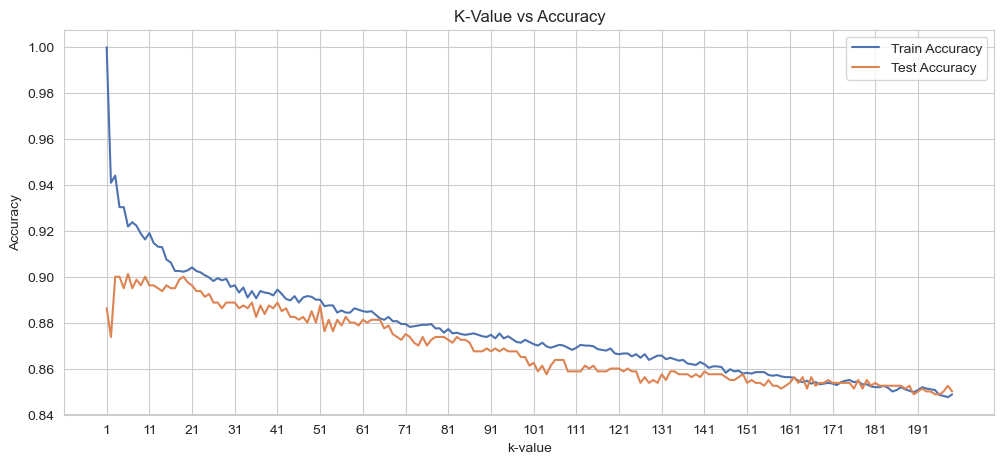

In [38]:
# We plot the results of our KNN classifier to see how the accuracy changes with the value of kvalue on both the training and test data,
# seeing where the underfitting and overfitting regions are.
# Plotting
plt.figure(figsize=(12, 5))
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('K-Value vs Accuracy')
plt.xlabel('k-value')
plt.ylabel('Accuracy')
#plt.xticks(list(k_values))  # Ensure that x-axis ticks match k values
tick_interval = 10
plt.xticks(range(1, len(k_values) + 1, tick_interval))
print('Best k-value:', k_values[np.argmax(test_accuracies)])
print('Max accuracy:', max(test_accuracies))
plt.show()

### Questions

These qre questions in the pdf file they are answered here. 

Q1: What kvalue had the best training accuracy?

A1: k = 1

Q2: What kvalue had the best testing accuracy?

A2: k = 6

Q3: What range of kvalues lead to underfitting?

A3: k > = 160, as per the graph

Q4: What range of kvalues lead to overfitting?

A4: k in [1,5]

Q5: Carefully explain and justify your answers by referring to specific regions of the plot and explain your knowledge of overfitting, underfitting, and fitting. 

A5: Underfitting is the region where a model has high bias and low variance, and where test accuracy would outperform training accuracy. Overfitting the region of this plot where a model has high variance and low bias, and where the training accuracy would outperform the test accuracy, as the model would be too specific to the training set. Finally, fitting is the region where the model has good bias and variance, such that the testing accuracy is typically at its highest, but is generally still slightly lower than training accuracy. Therefore, based on the above, in the graph, k=6 is the ideal fit of the model, k<6 is the region for overfitting, and underfitting occurs for k > =160.
